In [1]:
from sunpy.util import scraper
from sunpy.time import TimeRange, parse_time
import pandas as pd
import urllib
import matplotlib.pyplot as plt
from matplotlib import dates
import os

## Get the VLF data for transmitter of choice

In [2]:
vlf_pattern = "https://vlf.ap.dias.ie/data/Dunsink_{transmitter}_%Y-%m-%d_000000.csv"
vlf_scraper = scraper.Scraper(vlf_pattern, transmitter="DHO38")
files = vlf_scraper.filelist(TimeRange("2020-10-29", "2020-10-29"))
print(files)

['https://vlf.ap.dias.ie/data/Dunsink_DHO38_2020-10-29_000000.csv']


In [3]:
# check if the file is already downloaded, and if not download
if not os.path.exists(files[0].split('/')[-1]):
    urllib.request.urlretrieve(files[0], files[0].split('/')[-1])

In [4]:
def read_vlf_data(file):
    """
    Read VLF csv files and return a pandas Series
    """
    aa = pd.read_csv(file, comment="#", names=["date", "data"])
    sid = pd.Series(aa["data"].values, index=pd.to_datetime(aa["date"]))
    return sid

sid = read_vlf_data(files[0].split('/')[-1])

In [5]:
def get_recent_goes():
    """
    Pull the most recent GOES X-ray data from the NOAA page
    
    Returns the GOES short and long channels as pandas series
    """
    data = pd.read_json("https://services.swpc.noaa.gov/json/goes/primary/xrays-7-day.json")
    data_short = data[data["energy"]=="0.05-0.4nm"]
    data_long = data[data["energy"]=="0.1-0.8nm"]
    time_array = [parse_time(x).datetime for x in data_short['time_tag'].values]

    gl = pd.Series(data_long["flux"].values, index=time_array)
    gs = pd.Series(data_short["flux"].values, index=time_array)
    return gl, gs

gl, gs = get_recent_goes()

## Make specific plots

In [6]:
tstart = "2020-10-29 09:00"
tend = "2020-10-29 14:50"

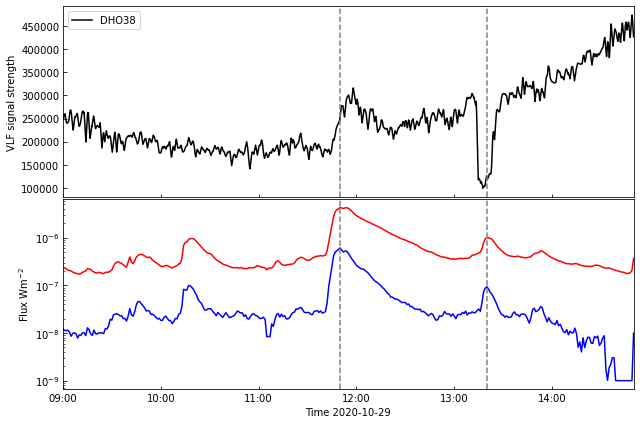

In [8]:
fig, ax = plt.subplots(2, sharex=True, figsize=(9, 6))

# plot the VLF data
ax[0].plot(sid.truncate(tstart, tend), label="DHO38", color="k")
ax[0].xaxis.set_major_formatter(dates.DateFormatter("%H:%M"))
ax[0].legend()

# plot the GOES data
ax[1].plot(gl.truncate(tstart, tend), color='r')
ax[1].plot(gs.truncate(tstart, tend), color='b')
ax[1].set_yscale("log")

for a in ax:
    a.axvline("2020-10-29 11:50", color="grey", ls="dashed")
    a.axvline("2020-10-29 13:20", color="grey", ls="dashed")
    a.tick_params(which="both", direction="in")

ax[0].set_ylabel("VLF signal strength")
ax[1].set_ylabel("Flux Wm$^{-2}$")
ax[1].set_xlabel("Time 2020-10-29")

ax[1].set_xlim(tstart, tend)
ax[1].xaxis.set_major_formatter(dates.DateFormatter("%H:%M"))

plt.tight_layout()
plt.subplots_adjust(hspace=0.01)

plt.savefig("DHO_flare_29102020.jpeg", dpi=200)
